In [10]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [11]:
fr = pd.read_csv(r'..\data\search\peak_finder\Final_Results.csv')
fr = fr.drop(fr.filter(regex='Unnamed').columns, axis=1)  # filter out the "Unnamed: " column 
fr.sample(20)

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64),20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67)
96,1.114,520.34003,+,3.474621e+09,LysoPC 18:2,LysoPC,3,1.134961e+04,1.931819e+04,3.707415e+07,...,5.240085e+08,2.501080e+08,2.001279e+08,2.518218e+08,5.654925e+08,1.515851e+08,1.987984e+08,1.167900e+04,1.050088e+04,1.013746e+04
1403,18.485,956.86365,+,1.303455e+07,TG 58:4,TG,18,1.586338e+04,1.450277e+04,6.845016e+05,...,1.143408e+06,8.533633e+05,1.656726e+06,4.107548e+05,4.010387e+06,3.110189e+05,2.682351e+06,2.004925e+04,1.402686e+04,2.262033e+04
1123,15.322,1068.34839,+,1.024320e+07,NaN,NaN,58,9.108788e+05,7.188847e+05,4.309518e+06,...,3.811224e+06,4.219934e+06,4.016990e+06,2.678581e+06,3.258136e+06,4.156599e+06,3.769063e+06,1.394255e+06,9.681803e+05,9.259399e+05
1479,20.144,948.89648,+,4.770309e+06,NaN,NaN,7,1.278086e+04,1.407593e+04,1.009094e+06,...,5.304679e+05,9.639982e+05,9.257888e+05,3.738636e+05,1.557582e+06,6.906385e+05,7.053896e+05,2.549970e+04,2.213956e+04,1.446670e+04
904,11.847,873.26788,+,1.470559e+07,NaN,NaN,62,1.843856e+06,1.373827e+06,6.647636e+06,...,3.738939e+06,4.375755e+06,4.926171e+06,2.677674e+06,3.565500e+06,3.778940e+06,2.686952e+06,1.667598e+04,9.956259e+05,8.091558e+05
48,0.692,680.95850,-,2.624111e+07,NaN,NaN,58,1.377815e+04,1.688565e+04,8.284500e+06,...,1.275546e+07,9.527600e+06,1.037221e+07,1.136822e+07,8.995204e+06,1.679176e+07,1.315244e+07,8.770304e+04,7.643696e+04,6.156085e+04
357,7.038,756.55524,+,1.720736e+06,PC 34:3,PC,9,1.952270e+04,4.317926e+04,5.620073e+05,...,1.176249e+06,6.338534e+05,8.239310e+05,3.879272e+05,1.371566e+06,6.326627e+05,8.482669e+05,2.748393e+04,1.793500e+04,1.763278e+04
924,12.230,772.27460,+,2.661885e+08,NaN,NaN,66,8.015472e+07,9.117253e+06,1.865079e+08,...,8.564054e+07,9.131486e+07,8.131188e+07,6.892098e+07,6.676768e+07,8.780624e+07,6.663057e+07,4.020871e+05,1.127833e+07,1.062311e+07
5,0.546,623.13641,+,2.010695e+08,NaN,NaN,55,5.377915e+03,5.448033e+03,1.933989e+08,...,1.161636e+08,1.583059e+08,7.533023e+07,1.192369e+08,1.640389e+08,1.511862e+08,9.581439e+07,6.500174e+03,5.707092e+03,5.757921e+03
25,0.665,515.00836,+,1.712571e+08,NaN,NaN,13,2.773414e+06,1.800230e+05,3.425124e+06,...,3.517858e+07,2.462976e+07,1.681324e+07,1.712571e+08,6.964784e+06,8.994129e+06,2.163404e+07,2.186816e+04,2.085023e+04,1.956935e+04


### Basic feature engineering:

1. Remove blank and water samples (5 total)

2. Separate into control vs test groups

3. Create 2nd pandas table of metadata compiled from Huishi's metadata info spreadsheet:
    1. "20210421_FBGRBGOGTT_Huishi sample sheet.xlsx"
    2. Include timepoints in pd.datetime format
    3. Include each rat's phenotypes (glucose level, insulin, weight, age, etc.) 
    
4. Explanation of sample metadata:
    1. Rat names: "T1060M", "T1061M", ... "T1102M" (not all number
        1. Not all numbers between 1060 and 1102 are included.
        2. NB: Not all rats had samples submitted for MS lipidomics
        
    2. RBG vs FBG 
        1. RBG = random blood glucose (randomly sampled blood glucose levels)
        2. FBG = fasted blood glucose (collected after fasting at pre-determined time intervals)
        
    3. Age
        1. Date of birth, between 1/23/2021 and 2/1/2021
        2. Metadata from Huishi organized based on "X weeks old" 
            1. Time points: 4, 8, 9, 10, 11, 12 weeks old 
            
     4. Weight
         1. Weights given as around 100, I assume this is grams
         2. Also gives "Weight gain %" or "Weight loss %"
         3. Also includes "Weight (pre-fasting)"
         3. Also includes "4 to 8 weeks" "Weight gain %"
         5. One of the weights has a note "euthanized due to tail injury" and blanks for that rat thereafter
            
     5. Date and time
         1. Given in "When" column
         2. Formats given as "3/26 6pm" or "4/10 10:30am" or "03/29 10:30am" 
      
    10. Other metadata:
        1. Note at top of metadata spreadsheet: "Fasting from 6:30pm to 10:30am; Light cycle 10am to 10pm"
            1. Referring to fasting periods for nile rats, and when the lights were on/off in the room
        2. "Collected hypothalamus, interscapular white fat, interscapular brown fat, inguinal white fat, mesenteric visceral white rat, pancreas, duodenum, jejunum, ileum, liver,"
        3. "Isoflurane 3% with 2L/min oxygen (~2min to go under)"
        4. Under the post-mortem phenotypes: "Used pre-fasting weight to calculate amount of dextrose"


In [171]:
## For easier grouping of files based on RBG vs FBG, analytical order, pairing of samples, and rat label,
## create a dataframe file_grouping that contains all labels and groups per analysis file.
## Columns = rawfile name; lipidex final results filename; order; RBG vs FBG; rat number labels

file_grouping = pd.read_csv(r'..\data\metadata\20210729_AJ_Toh_RatPlasma_Sequence_Exported.csv', skiprows=1)
file_grouping['analytical_run_order'] = range(1, 68)
file_grouping = file_grouping[['File Name', 'analytical_run_order']]

rawfile_cols = fr.filter(regex='.raw').columns

# Dictionary of rawfile names to Lipidex final results file names (which includes (F1), (F2), etc. in column name)
sample_name_to_file_name_map = {}

for file in rawfile_cols.to_list():
    for sfile in file_grouping['File Name'].to_list():
        if sfile in file:
            sample_name_to_file_name_map[sfile] = file

# correlates rawfile name to lipidex final results filename
file_grouping['fr_name'] = file_grouping['File Name'].apply(lambda name: sample_name_to_file_name_map[name] )
    
# Extract the rat label from filename using this horrible chain of str.split() methods 
file_grouping['rat_label'] = file_grouping[file_grouping['File Name'].str.contains('Glucose_T')]['File Name'] \
                                           .str.split('Glucose_T').str[1] \
                                           .str.split('M_2021').str[0] 

def parse_bg_type(filename):
    if 'RBG' in filename:
        return 'RBG'
    if 'FBG' in filename:
        return 'FBG'

file_grouping['bg_type'] = file_grouping[file_grouping['File Name'].str.contains('RBG|FBG')]['File Name'] \
                                         .apply(parse_bg_type)

# if a file has quant_file == True, then it's one of the 60 runs we will use for data analysis
file_grouping['quant_file'] = ~file_grouping['analytical_run_order'].isin([1,2,3,4,5,6,67])

# extract the week label from filename using chain of str.split()
file_grouping['week'] = file_grouping[file_grouping['File Name'].str.contains('Glucose_T')]['File Name'] \
                                           .str.split('_').str[6] \
                                           .str.split('wk').str[0].astype('float')
file_grouping['lipidex_file_number'] = 

In [172]:
file_grouping.head(10)


,File Name,analytical_run_order,fr_name,rat_label,bg_type,quant_file,week
0,20210729_AJ_Toh_RatBloodGlucose_Water_R1,1,20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),NaN,NaN,False,NaN
1,20210729_AJ_Toh_RatBloodGlucose_Water_R2,2,20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),NaN,NaN,False,NaN
2,20210729_AJ_Toh_RatBloodGlucose_Water_R3,3,20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67),NaN,NaN,False,NaN
3,20210729_AJ_Toh_RatBloodGlucose_SolventBlank,4,20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),NaN,NaN,False,NaN
4,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank,5,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),NaN,NaN,False,NaN
5,20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC1,6,20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC1.raw (F11),1062,FBG,False,9.0
6,20210729_AJ_Toh_RatBloodGlucose_T1076M_20210405_10wk_FBG,7,20210729_AJ_Toh_RatBloodGlucose_T1076M_20210405_10wk_FBG.raw (F27),1076,FBG,True,10.0
7,20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG,8,20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG.raw (F9),1062,FBG,True,8.0
8,20210729_AJ_Toh_RatBloodGlucose_T1093M_20210402_9wk_FBG,9,20210729_AJ_Toh_RatBloodGlucose_T1093M_20210402_9wk_FBG.raw (F49),1093,FBG,True,9.0
9,20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG,10,20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),1060,RBG,True,8.0


In [174]:
file_grouping[file_grouping['week'] == 9]

,File Name,analytical_run_order,fr_name,rat_label,bg_type,quant_file,week
5,20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC1,6,20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC1.raw (F11),1062,FBG,False,9.0
8,20210729_AJ_Toh_RatBloodGlucose_T1093M_20210402_9wk_FBG,9,20210729_AJ_Toh_RatBloodGlucose_T1093M_20210402_9wk_FBG.raw (F49),1093,FBG,True,9.0
11,20210729_AJ_Toh_RatBloodGlucose_T1092M_20210406_9wk_RBG,12,20210729_AJ_Toh_RatBloodGlucose_T1092M_20210406_9wk_RBG.raw (F44),1092,RBG,True,9.0
14,20210729_AJ_Toh_RatBloodGlucose_T1060M_20210401_9wk_RBG,15,20210729_AJ_Toh_RatBloodGlucose_T1060M_20210401_9wk_RBG.raw (F6),1060,RBG,True,9.0
15,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210402_9wk_FBG,16,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210402_9wk_FBG.raw (F55),1101,FBG,True,9.0
20,20210729_AJ_Toh_RatBloodGlucose_T1076M_20210329_9wk_FBG,21,20210729_AJ_Toh_RatBloodGlucose_T1076M_20210329_9wk_FBG.raw (F25),1076,FBG,True,9.0
21,20210729_AJ_Toh_RatBloodGlucose_T1092M_20210402_9wk_FBG,22,20210729_AJ_Toh_RatBloodGlucose_T1092M_20210402_9wk_FBG.raw (F43),1092,FBG,True,9.0
24,20210729_AJ_Toh_RatBloodGlucose_T1082M_20210329_9wk_FBG,25,20210729_AJ_Toh_RatBloodGlucose_T1082M_20210329_9wk_FBG.raw (F31),1082,FBG,True,9.0
27,20210729_AJ_Toh_RatBloodGlucose_T1093M_20210406_9wk_RBG,28,20210729_AJ_Toh_RatBloodGlucose_T1093M_20210406_9wk_RBG.raw (F50),1093,RBG,True,9.0
30,20210729_AJ_Toh_RatBloodGlucose_T1074M_20210401_9wk_RBG,31,20210729_AJ_Toh_RatBloodGlucose_T1074M_20210401_9wk_RBG.raw (F20),1074,RBG,True,9.0


In [159]:
## T1062M_20210329_9wk_FBG Is sampled 3 times, each with a QC label.
## The 1st QC has low quants and we could ignore.
## The 2nd and 3rd QC appear OK, so use the QC2 as the one to include in all samples
## There is no non-QC file for T1062M_20210329_9wk_FBG

qc1qc3 = fr.filter(regex='QC1|QC3')

blanks = fr.filter(regex='Blank|Water')

fbg = fr.filter(regex='FBG')
fbg.columns  ## Beware that QCs are still in this

rbg = fr.filter(regex='RBG')

In [14]:
## Which animals were used in the experiment? 
## Because not all animals in the metadata had samples submitted for plasma lipidomics

cols = fr.columns

animal_numbers = []

for col in cols:
#     print(col)
    search = re.search(r"(?<=ose\_T)(.*)(?=M_)", str(col))
    if search:
#         print(search.groups()[0])
        animal_numbers.append(search.groups()[0])
    
animals_used = list(set(animal_numbers))
print(animals_used)  # ['1074', '1076', '1062', '1093', '1082', '1101', '1092', '1102', '1091', '1060']

['1074', '1076', '1062', '1093', '1082', '1101', '1092', '1102', '1091', '1060']


In [152]:
# obs is the dataframe of observations collected by collaborators. 
# data were originally in a pivoted format, so observations were cleaned into "tidy data format"

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')

# Remove the T and M from T1060M
obs['animal'] = obs['animal'].str.strip('TM').astype('int')

# derive datetime column from 'when' column
# dateutil pandas library makes it easy to parse, it guessed right the first time 
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
# display(obs['datetime'].to_list())

# There were 19 rats in the study, but only 10 had samples subjected to LCMS analysis
# obs[obs['animal'].isin(animals_used)]

obs[obs['animal'] == 1060]

,animal,when,BG,weight,weight change %,BG type,weight type,weight change type,weeks old note,note,datetime
0,1060,2/20 3pm,71.0,53.7,NaN,RBG,Weight,change,4 weeks old,NaN,2021-02-20 15:00:00
19,1060,3/21 6pm,255.0,90.2,NaN,RBG (pre-fasting),Weight (pre-fasting),change,NaN,NaN,2021-03-21 18:00:00
38,1060,3/22 10:30am,41.0,85.4,5.321508,FBG,Weight,loss,8 weeks old,NaN,2021-03-22 10:30:00
57,1060,3/25 3pm,225.0,92.6,72.439479,RBG,Weight,gain 4 to 8 weeks,8 weeks old,NaN,2021-03-25 15:00:00
76,1060,03/28 6pm,NaN,96.0,NaN,RBG (pre-fasting),Weight (pre-fasting),NaN,NaN,NaN,2021-03-28 18:00:00
95,1060,03/29 10:30am,48.0,90.9,5.312500,FBG,Weight,loss,9 weeks old,NaN,2021-03-29 10:30:00
114,1060,4/1 3pm,83.0,98.1,5.939525,RBG,Weight,8 to 9 weeks gain,9 weeks old,NaN,2021-04-01 15:00:00
133,1060,4/4 6pm,NaN,101.3,NaN,RBG,Weight (pre-fasting),NaN,NaN,NaN,2021-04-04 18:00:00
152,1060,4/5 10:30am,52.5,94.9,6.317868,FBG,Weight,NaN,10 weeks old,NaN,2021-04-05 10:30:00
171,1060,4/8 3pm,206.0,100.9,2.854230,RBG,Weight,9 to 10 weeks gain,10 weeks old,NaN,2021-04-08 15:00:00


In [150]:
obs.dtypes

animal                         int32
when                          object
BG                           float64
weight                       float64
weight change %              float64
BG type                       object
weight type                   object
weight change type            object
weeks old note                object
note                          object
datetime              datetime64[ns]
dtype: object

### MS data quality first passes 

### 1a. Feature quant boxplots per QC

Text(0.5, 1.0, 'Quality Control Samples\nFeature Quantitations')

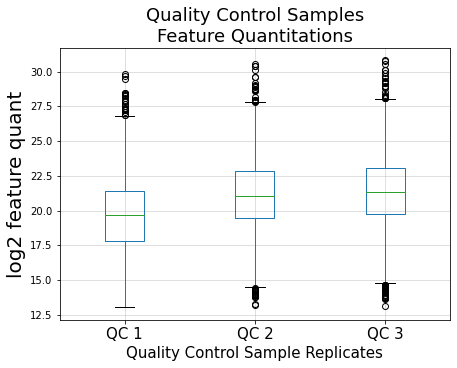

In [17]:
np.log2(fr.filter(regex='QC')).boxplot()
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches((7, 5))
ax.grid(True, alpha=0.5)
plt.xticks([1, 2, 3], labels=['QC 1', 'QC 2', 'QC 3'], fontsize=15)
plt.xlabel('Quality Control Sample Replicates', fontsize=15)
plt.ylabel('log2 feature quant', fontsize=20)
plt.title('Quality Control Samples\nFeature Quantitations', fontsize=18)


### 1b. Feature quant boxplots across samples 

In [21]:
# Re-order columns in samples df into analytical order

rawfile_cols = fr.filter(regex='.raw').columns
print(analytical_order)

sample_name_to_file_name_map = {}

for file in rawfile_cols.to_list():
    for sfile in analytical_order['File Name'].to_list():
        if sfile in file:
            sample_name_to_file_name_map[sfile] = file

analytical_order['sample name'] = analytical_order['File Name'].apply(lambda name: sample_name_to_file_name_map[name] )

                                            File Name  order
0            20210729_AJ_Toh_RatBloodGlucose_Water_R1      1
1            20210729_AJ_Toh_RatBloodGlucose_Water_R2      2
2            20210729_AJ_Toh_RatBloodGlucose_Water_R3      3
3        20210729_AJ_Toh_RatBloodGlucose_SolventBlank      4
4     20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank      5
..                                                ...    ...
62  20210729_AJ_Toh_RatBloodGlucose_T1062M_2021040...     63
63  20210729_AJ_Toh_RatBloodGlucose_T1101M_2021033...     64
64  20210729_AJ_Toh_RatBloodGlucose_T1092M_2021033...     65
65  20210729_AJ_Toh_RatBloodGlucose_T1092M_2021041...     66
66  20210729_AJ_Toh_RatBloodGlucose_T1062M_2021032...     67

[67 rows x 2 columns]


In [24]:
# increase how many chars gets printed pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_colwidth', None)

# Get only the data files (minus blanks and QC1 and QC3)
analysis_file_indices = list(range(6, 66))
analysis_files = analytical_order.iloc[analysis_file_indices]
analysis_files.loc[:, 'order'] = range(0, 60)
analysis_files

# Re-order the columns using .reindex()
samples = analysis_files.reindex(columns=analysis_files['sample name'])
samples

C:\Users\bjanderson23\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


sample name,20210729_AJ_Toh_RatBloodGlucose_T1076M_20210405_10wk_FBG.raw (F27),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG.raw (F9),20210729_AJ_Toh_RatBloodGlucose_T1093M_20210402_9wk_FBG.raw (F49),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),20210729_AJ_Toh_RatBloodGlucose_T1091M_20210410_10wk_FBG.raw (F39),20210729_AJ_Toh_RatBloodGlucose_T1092M_20210406_9wk_RBG.raw (F44),20210729_AJ_Toh_RatBloodGlucose_T1093M_20210413_10wk_RBG.raw (F52),20210729_AJ_Toh_RatBloodGlucose_T1082M_20210405_10wk_FBG.raw (F33),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210401_9wk_RBG.raw (F6),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210402_9wk_FBG.raw (F55),...,20210729_AJ_Toh_RatBloodGlucose_T1092M_20210410_10wk_FBG.raw (F45),20210729_AJ_Toh_RatBloodGlucose_T1082M_20210325_8wk_RBG.raw (F30),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210325_8wk_RBG.raw (F10),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1093M_20210330_8wk_RBG.raw (F48),20210729_AJ_Toh_RatBloodGlucose_T1074M_20210329_9wk_FBG.raw (F19),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210401_9wk_RBG.raw (F14),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210330_8wk_RBG.raw (F54),20210729_AJ_Toh_RatBloodGlucose_T1092M_20210330_8wk_RBG.raw (F42),20210729_AJ_Toh_RatBloodGlucose_T1092M_20210413_10wk_RBG.raw (F46)
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
# List of all final results filenames that we use for quantitation (i.e. no QC, no blanks) in analytical order
fr_quant_filenames_in_analytical_order = file_grouping[file_grouping['quant_file'] == True]['fr_name'].to_list()

fr_quant_filenames_in_analytical_order

['20210729_AJ_Toh_RatBloodGlucose_T1076M_20210405_10wk_FBG.raw (F27)',
 '20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG.raw (F9)',
 '20210729_AJ_Toh_RatBloodGlucose_T1093M_20210402_9wk_FBG.raw (F49)',
 '20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4)',
 '20210729_AJ_Toh_RatBloodGlucose_T1091M_20210410_10wk_FBG.raw (F39)',
 '20210729_AJ_Toh_RatBloodGlucose_T1092M_20210406_9wk_RBG.raw (F44)',
 '20210729_AJ_Toh_RatBloodGlucose_T1093M_20210413_10wk_RBG.raw (F52)',
 '20210729_AJ_Toh_RatBloodGlucose_T1082M_20210405_10wk_FBG.raw (F33)',
 '20210729_AJ_Toh_RatBloodGlucose_T1060M_20210401_9wk_RBG.raw (F6)',
 '20210729_AJ_Toh_RatBloodGlucose_T1101M_20210402_9wk_FBG.raw (F55)',
 '20210729_AJ_Toh_RatBloodGlucose_T1062M_20210408_10wk_RBG.raw (F16)',
 '20210729_AJ_Toh_RatBloodGlucose_T1091M_20210330_8wk_RBG.raw (F36)',
 '20210729_AJ_Toh_RatBloodGlucose_T1074M_20210405_10wk_FBG.raw (F21)',
 '20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58)',
 '20210729_AJ_To

Text(0.5, 1.0, 'All Samples\nFeature Quantitations')

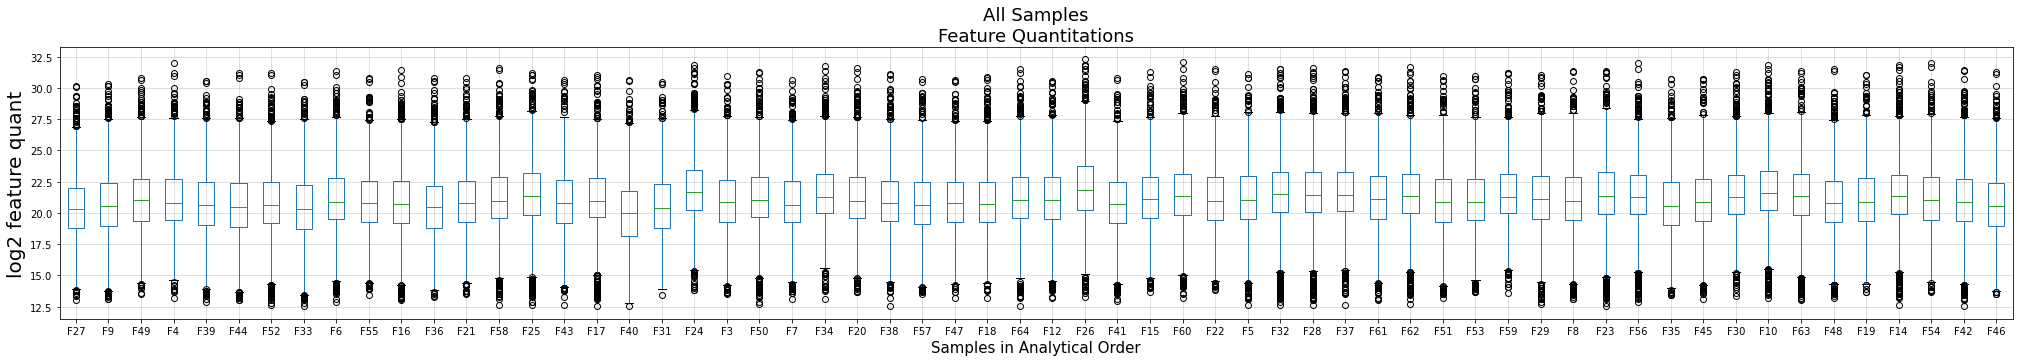

In [506]:
np.log2(samples).boxplot()
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches((35, 5))
ax.grid(True, alpha=0.5)
labels = [re.search(r'\((.*?)\)', col_name).group(1) for col_name in samples.columns.to_list()]
plt.xticks(range(1, 61), labels=labels)
# plt.xticks(range(1, 61), labels=samples.columns.to_list(), fontsize=15, rotation=90)
plt.xlabel('Samples in Analytical Order', fontsize=15)
plt.ylabel('log2 feature quant', fontsize=20)
plt.title('All Samples\nFeature Quantitations', fontsize=18)

### 1c. Do a breakdown of 2 boxplots per animal, one F, one R. 
20 total boxplots, show groupings

### 2. PCA groupings by RBG vs FBG

scikitlearn's PCA needs the thing you're trying to separate on in rows, therefore take the Transpose of fr

In [427]:
tp = fr.drop(fr.filter(regex='Blank|Water|QC1|QC2').columns, axis=1).filter(regex='.raw').T
# display(tp)

# populate label column based on whether RBG or FBG in sample name
# lambda general form: lambda <arguments> : <Return Value if cond. True> if <condition> else <Return Value if cond. False>

tp['bg label'] = tp.index.map(lambda index: 'RBG' if 'RBG' in index else 'FBG')  # df.index.apply doesn't work, have to use df.index.map
# tp['label'].value_counts()

def rat_label_func(index):
    return index.split('Glucose_T')[1].split('M_')[0]

tp['rat label'] = tp.index.map(rat_label_func)
tp

,0,1,2,3,4,5,6,7,8,9,...,1479,1480,1481,1482,1483,1484,1485,1486,bg label,rat label
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),1.145548e+07,4.677270e+07,1.625939e+07,1.290199e+08,1.089197e+07,1.933989e+08,2.044391e+09,3.911514e+05,6.825097e+06,1.069831e+08,...,1.009094e+06,1.695971e+06,6.585959e+05,1.801313e+06,1.053780e+06,5.844701e+05,1.669550e+04,4.172293e+05,FBG,1060
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),1.728814e+07,5.522238e+07,3.238113e+07,6.760284e+07,1.697296e+07,1.685820e+08,4.234264e+09,4.231877e+05,5.076570e+06,1.380264e+08,...,3.590850e+05,2.521954e+05,3.591638e+05,1.867413e+05,7.649254e+04,2.637219e+05,2.006306e+05,1.935145e+05,RBG,1060
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210329_9wk_FBG.raw (F5),1.620891e+07,4.636132e+07,2.424065e+07,2.097893e+08,1.411260e+07,1.976960e+08,2.277230e+09,5.282407e+05,6.153004e+06,1.163225e+08,...,1.478886e+06,2.084620e+06,6.962952e+05,2.262484e+06,1.532065e+06,4.822433e+05,6.497595e+04,3.182338e+05,FBG,1060
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210401_9wk_RBG.raw (F6),2.381849e+07,3.699951e+07,9.969525e+06,2.170599e+08,5.828327e+06,7.780203e+07,9.474041e+08,3.177282e+05,7.656925e+06,5.256910e+07,...,5.292559e+05,3.282916e+05,4.957885e+05,2.249304e+05,9.603305e+04,3.785893e+05,2.022126e+05,2.218873e+05,RBG,1060
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210405_10wk_FBG.raw (F7),1.396265e+07,2.186571e+07,1.224058e+07,1.517546e+08,7.216628e+06,7.340653e+07,8.894795e+08,2.945614e+05,5.584367e+06,4.536340e+07,...,2.809178e+05,8.838342e+05,2.268937e+05,1.017417e+06,7.220460e+05,1.172392e+05,1.566261e+04,1.552374e+04,FBG,1060
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210408_10wk_RBG.raw (F8),1.222901e+07,3.143719e+07,2.428798e+07,2.321839e+08,1.110572e+07,1.128582e+08,1.598987e+09,4.484599e+05,3.024460e+06,9.202207e+07,...,4.578285e+05,1.921003e+05,3.742060e+05,1.673797e+05,4.768530e+04,2.973711e+05,9.491840e+04,2.005374e+05,RBG,1060
20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG.raw (F9),1.049443e+07,2.537288e+07,1.402438e+07,1.187355e+08,6.906003e+06,8.068469e+07,1.338627e+09,2.933464e+05,4.245591e+06,7.975980e+07,...,1.952125e+05,6.713921e+05,1.696026e+05,6.228681e+05,3.955002e+05,8.184697e+04,1.504719e+04,8.400065e+04,FBG,1062
20210729_AJ_Toh_RatBloodGlucose_T1062M_20210325_8wk_RBG.raw (F10),7.822806e+06,1.570121e+07,1.428936e+07,1.913929e+08,6.922304e+06,5.853739e+07,1.622974e+09,3.731273e+05,6.153203e+06,9.289272e+07,...,1.073021e+06,7.017587e+05,5.502279e+05,6.014441e+05,1.172183e+05,8.610503e+05,7.842521e+05,5.191814e+05,RBG,1062
20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC3.raw (F13),1.542432e+07,2.781395e+07,1.909527e+07,1.704727e+08,1.127505e+07,1.098175e+08,1.616395e+09,5.433544e+05,8.016773e+06,9.441872e+07,...,2.908438e+05,8.190441e+05,3.055210e+05,9.655321e+05,5.114760e+05,7.828641e+04,1.584800e+04,1.253009e+05,FBG,1062
20210729_AJ_Toh_RatBloodGlucose_T1062M_20210401_9wk_RBG.raw (F14),1.580575e+07,8.711962e+06,2.507414e+07,2.456139e+08,1.370329e+07,7.282328e+07,1.814210e+09,2.601523e+05,7.476980e+06,1.158570e+08,...,7.870235e+05,3.781001e+05,6.239018e+05,3.012837e+05,7.378381e+04,5.009631e+05,4.241803e+05,3.184388e+05,RBG,1062


In [431]:
pca = PCA(n_components=2)

scaled = StandardScaler().fit_transform(tp.drop(['bg label', 'rat label'], axis=1))
print(scaled)
fitted = pca.fit_transform(scaled)
fitted = pd.DataFrame(fitted, columns=['pc1','pc2'])

merged = pd.concat([fitted, tp.reset_index()[['bg label', 'rat label']]], axis=1)
# merged

[[-0.80173133  1.18701423 -0.38841491 ...  0.17292186 -0.50945109
   0.29757339]
 [ 0.53787972  1.89780289  2.13619235 ... -0.38230301 -0.18663173
  -0.29698932]
 [ 0.29000902  1.15240859  0.86142233 ... -0.00403575 -0.4247154
   0.03447503]
 ...
 [-0.46895399  0.44054005  0.12347275 ...  1.14714371  1.38754198
   0.93363174]
 [-0.3233844  -0.0389642   0.12519426 ... -0.07111954 -0.48869863
  -0.11675951]
 [-0.30713897 -0.31713637 -0.51757122 ...  0.11481992  0.39037175
   0.08742359]]


In [441]:
animals_used

['1101',
 '1092',
 '1062',
 '1082',
 '1102',
 '1091',
 '1076',
 '1060',
 '1074',
 '1093']

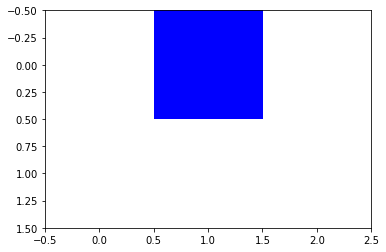

In [485]:
from matplotlib.colors import from_levels_and_colors
cmap, norm = from_levels_and_colors([0,1,2,3],['red','green','blue'])
plt.imshow(np.array([[,2,3,],[4,5,6,]]), cmap=cmap, norm=norm)

In [491]:
cmap, norm = from_levels_and_colors(list(range(0,10)),['red', 'blue'], extend='max')

ValueError: With extend == 'max' and 10 levels, expected 10 colors, but got 2

In [482]:
from matplotlib import cm

cmap = cm.get_cmap('Dark2', 20)
print(cmap)
cmap(np.arange(0, 0.9, 1/10))



array([[0.10588235, 0.61960784, 0.46666667, 1.        ],
       [0.10588235, 0.61960784, 0.46666667, 1.        ],
       [0.85098039, 0.37254902, 0.00784314, 1.        ],
       [0.45882353, 0.43921569, 0.70196078, 1.        ],
       [0.90588235, 0.16078431, 0.54117647, 1.        ],
       [0.4       , 0.65098039, 0.11764706, 1.        ],
       [0.90196078, 0.67058824, 0.00784314, 1.        ],
       [0.90196078, 0.67058824, 0.00784314, 1.        ],
       [0.65098039, 0.4627451 , 0.11372549, 1.        ]])

In [451]:
for x in range(0.1, 0.8, 0.1):
    print(x)

TypeError: 'float' object cannot be interpreted as an integer

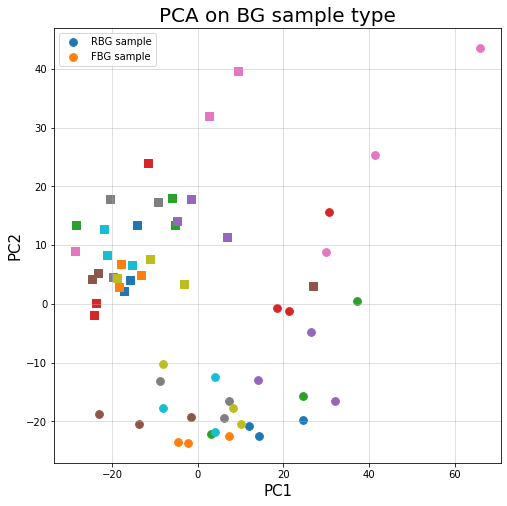

In [503]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA on BG sample type', fontsize = 20)
targets = ['RBG', 'FBG']
markers = ['o', 's']
rat_labels = ['1101', '1092', '1062', '1082', '1102', '1091', '1076', '1060', '1074', '1093']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = [plt.get_cmap('Dark2')(i) for i in range(1, 11)]

for target, marker in zip(targets,markers):
    for label, color in zip(rat_labels, colors):
        scatter_points = merged[(merged['bg label'] == target) & (merged['rat label'] == label)]
        ax.scatter(scatter_points['pc1'],
                   scatter_points['pc2'],
#                    c = color,
#                    cmap='viridis',
                   marker=marker,
                   s = 60)
ax.legend(['RBG sample', 'FBG sample'],)
ax.grid(alpha=0.5)

In [ ]:
## Modification to add arrow-lines between week 8, 9 and 10

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA on BG sample type', fontsize = 20)
targets = ['RBG', 'FBG']
markers = ['o', 's']
rat_labels = ['1101', '1092', '1062', '1082', '1102', '1091', '1076', '1060', '1074', '1093']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = [plt.get_cmap('Dark2')(i) for i in range(1, 11)]

for target, marker in zip(targets,markers):
    for label, color in zip(rat_labels, colors):
        scatter_points = merged[(merged['bg label'] == target) & (merged['rat label'] == label)]
        ax.scatter(scatter_points['pc1'],
                   scatter_points['pc2'],
#                    c = color,
#                    cmap='viridis',
                   marker=marker,
                   s = 60)
ax.legend(['RBG sample', 'FBG sample'],)
ax.grid(alpha=0.5)

### 3. Lipid class breakdown

In [518]:
analysis_cols = analysis_files['sample name'].to_list()

In [528]:
# Unique lipid classes

unique_classes = fr['Lipid Class'].unique()[1:]
unique_classes

array(['LysoPI', 'AC', 'LysoPC', 'LysoPE', 'PC', 'Alkenyl-DG', 'PI', 'SM',
       'Plasmenyl-PC', 'Plasmanyl-PC', 'Plasmenyl-PE', 'PE',
       'Plasmanyl-PE', 'Cer[NS]', 'TG', 'CE'], dtype=object)

In [9]:
analysis_order

NameError: name 'analysis_order' is not defined

Text(0.5, 1.0, 'FBG Triacylglycerol (TG) levels')

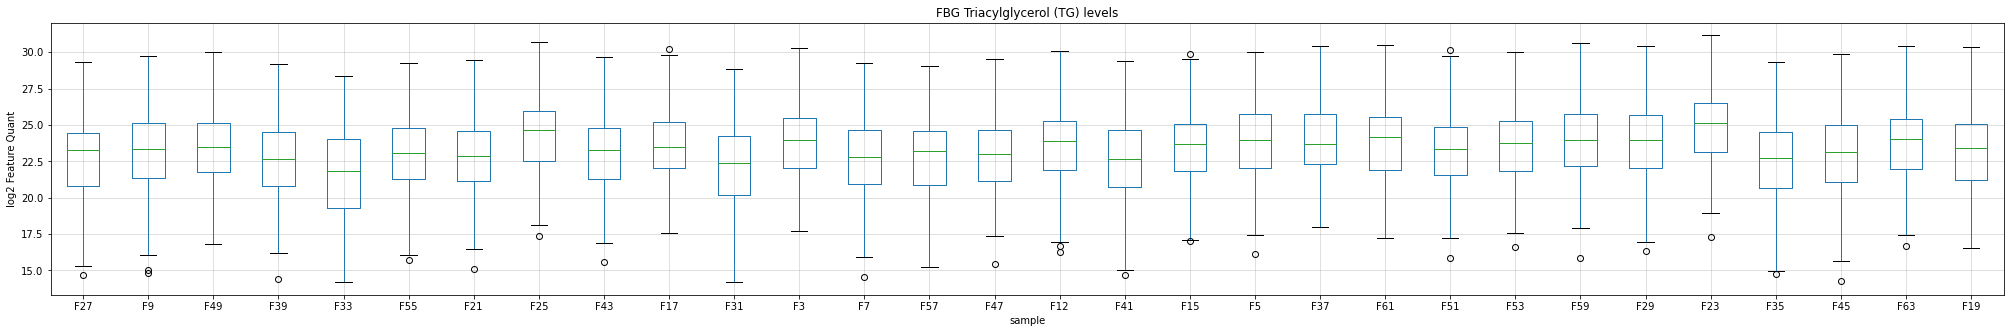

In [542]:
tg_quants = fr[analysis_cols][fr['Lipid Class'] == 'TG']

fbg_tg_quants = tg_quants.filter(regex='FBG')

np.log2(fbg_tg_quants).boxplot()
fig = plt.gcf()
fig.set_size_inches((35, 5))
ax = plt.gca()
ax.grid(True, alpha=0.5)

labels = [re.search(r'\((.*?)\)', col_name).group(1) for col_name in fbg_tg_quants.columns.to_list()]


plt.xticks(ticks=list(range(1, fbg_tg_quants.shape[1] + 1)), 
           labels=labels);
plt.xlabel('sample')
plt.ylabel('log2 Feature Quant')
plt.title('FBG Triacylglycerol (TG) levels')






<AxesSubplot:>

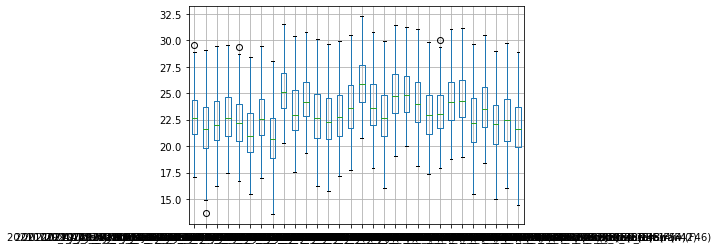

In [532]:
np.log2(tg_quants.filter(regex='RBG')).boxplot()

     principal component 1  principal component 2
0                -2.684207               0.326607
1                -2.715391              -0.169557
2                -2.889820              -0.137346
3                -2.746437              -0.311124
4                -2.728593               0.333925
..                     ...                    ...
145               1.944017               0.187415
146               1.525664              -0.375021
147               1.764046               0.078519
148               1.901629               0.115877
149               1.389666              -0.282887

[150 rows x 2 columns]


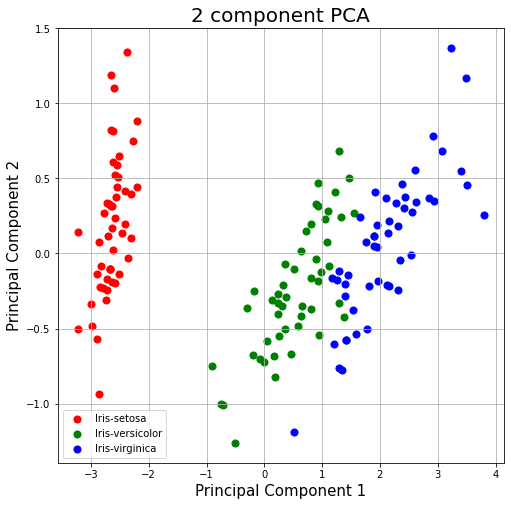

In [119]:
# from https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"  # load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

from sklearn.preprocessing import StandardScaler

# lengths and widths are floats, target="Iris-setosa" or "virginica" or "versicolor"

features = ['sepal length', 'sepal width', 'petal length', 'petal width']# Separating out the features
x = df.loc[:, features].values# Separating data from the target flower type
y = df.loc[:,['target']].values# Standardizing the features
# print(x)
# print(y)

# StandardScaler turns it into mean=0, variance=1 (this is sensitive to outliers though, no?)
x = StandardScaler().fit_transform(x)
# print(x)
from sklearn.decomposition import PCA

# Instantiate a pca object with 2 components
pca = PCA(n_components=2)

# populate the PCA by fit_transform the standardized data
# fit_transform returns a 2-D array with dim (n_components columns x # of Rows)
principalComponents = pca.fit_transform(x)
# print(principalComponents)

# make new df 
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Basically, you could have done the sklearn fitting directly on the pandas DF with appropriate cols
# https://stackoverflow.com/questions/23282130/principal-components-analysis-using-pandas-dataframe
finalDf = pd.concat([principalDf, df['target']], axis = 1)

better_df = pd.DataFrame(pca.fit_transform(df[features]), columns=['principal component 1', 'principal component 2'])
print((better_df))
better_final = pd.concat([better_df, df['target']], axis=1)


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = better_final['target'] == target
    ax.scatter(better_final.loc[indicesToKeep, 'principal component 1']
               , better_final.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()